In [1]:
#Imports
import json
import numpy as np
import pandas as pd
import csv
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
def jasonReader(path):
    """ Reads the .jason generated with jasonGenartor the given path"""
    with open(path,'r') as miarch:
        loaded_dict = json.loads(miarch.read())
    return loaded_dict

In [1]:
def wholecellParser(dictres):
    #extract all the slices data
    allSlices = dictres['image']
    #seting columns names
    column_names = ['max_peaks_positions','max_peaks_intensities','min_peaks_positions','min_peaks_intensities','amplitudes','times_to_peaks','tau_s']
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in column_names:
        df_sum.loc[:,i] = allSlices[i][:2]

    return df_sum

### Precisión y exactitud amplitud

In [4]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/jsons/'
file_tabulado = pd.read_excel(path + 'tab_prueba2.xlsx')
del file_tabulado['Unnamed: 0']

In [94]:
df_manual = pd.read_csv("/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/DI_manual_1hz.csv", sep=",")
df_manual.head(2)

,experimento,foto,pico,Intensidad_max,tiempo_max,Intensidad_min,tiempo_min,Amplitud,TTP,TTP_manual
0,200121,C1a000,1,43.19,125,17.89,118,1.414198,7,4.949802
1,200121,C1a000,2,42.64,360,16.80,354,1.538095,6,3.900929


In [6]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/'
experiments = os.listdir(path + 'jsons/')
dif_amp = pd.DataFrame()
dias = df_manual['experimento'].drop_duplicates()
foto = df_manual['foto'].drop_duplicates()
for j in dias:
    for k in foto:
        for i in range(0,len (experiments)):
            if (str(j) in experiments[i]) & (k in experiments[i]):
                try:
                    experiment = jasonReader(path + 'jsons/' + experiments[i])
                    df_file = wholecellParser(experiment)
                    df_file['file'] = experiments[i]
                    dif_amp = dif_amp.append(df_file, ignore_index=True)
                except:
                    print(experiments[i])

In [7]:
dif_amp.to_csv('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/amp_cadiap_5hz.csv')

In [95]:
amp_cardiap = pd.read_csv('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/amp_cadiap.csv')
amp_cardiap.head(2)

,Unnamed: 0,max_peaks_positions,max_peaks_intensities,min_peaks_positions,min_peaks_intensities,amplitudes,times_to_peaks,file,TTP_norm
0,0,37.0,30,18.0,13,1.307692,19,200121_analysis_result_c1a000.json,14.529412
1,1,272.0,29,253.0,13,1.230769,19,200121_analysis_result_c1a000.json,15.437499


In [96]:
import scipy.stats

x = amp_cardiap['TTP_norm'].dropna()
y = df_manual ['TTP_manual'].dropna()
scipy.stats.pearsonr(x, y)

(0.8935940962854456, 2.5574915153991222e-18)

In [97]:
df = pd.DataFrame((x,y)).T
def outliers(df,column,percentiles):
    Q1 = df[column].quantile(percentiles[0])
    Q3 = df[column].quantile(percentiles[1])
    IQR = Q3 - Q1
    idx = ~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))
    df = df[idx.values]
    return df

df = outliers(df,'TTP_norm',[0.02,0.98])
df = outliers(df,'TTP_manual',[0.02,0.98])

Text(0, 0.5, 'TTP-manual')

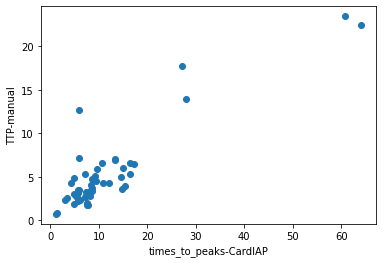

In [98]:
import matplotlib.pyplot as pp

# plot
pp.scatter(df['TTP_norm'],df['TTP_manual'])
pp.xlabel('times_to_peaks-CardIAP')
pp.ylabel('TTP-manual')

# pp.savefig('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/TTP_cadiap_1hz.png')

Text(0, 1, 'r-squared = 0.291')

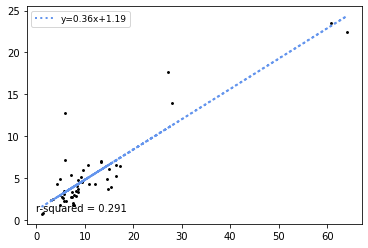

In [99]:
from scipy import stats
from sklearn.metrics import r2_score
#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

line = slope*x+intercept
lines = plt.plot(x, line, 'cornflowerblue', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
#end
plt.setp(lines, color='cornflowerblue', linewidth=2.0,linestyle = ':')
plt.scatter(x,y, color="k", s=3.5)
plt.legend(fontsize=9)
plt.annotate("r-squared = {:.3f}".format(r2_score(x, y)), (0, 1))
# pp.savefig('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/TTP_cadiap_1hz.png')

In [22]:
from statistics import variance

diff = x[:48]-y[:48]
print(diff.mean())
print(diff.std())
print(x[:48].mean(),x[:48].std(),variance(x[:48]),y[:48].mean(),y[:48].std(),variance(y[:48]))

10.791666666666666
2.79024389487869
20.791666666666668 2.041675712818286 4.168439716312057 10.0 2.820894682279124 7.957446808510638


In [23]:
stats.ttest_1samp(diff, 0.0)

Ttest_1sampResult(statistic=26.79581523224053, pvalue=4.025477459164595e-30)

In [24]:
scipy.stats.levene(x[:48],y[:48],center='trimmed', proportiontocut=0.05)

LeveneResult(statistic=12.230116266580618, pvalue=0.0007466054493280572)

## Análisis de AR

In [60]:
path_ar = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/ARs/'

In [66]:
path_tabulado = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/seleccion/'
file_tabulado = pd.read_csv(path_tabulado + 'tabulado_imagenes.csv')
del file_tabulado['Unnamed: 0']

In [76]:
experiments = os.listdir(path_ar)
dif_amp = []
dias = file_tabulado['experimento'].drop_duplicates()
foto = file_tabulado['foto'].drop_duplicates()
for j in dias:
    for k in foto:
        for i in range(0,len (experiments)):
            if (str(j) in experiments[i]) & (k in experiments[i]):
                file_tabulado['experimento']
                ar = pd.read_csv(path_ar + experiments[i],sep='\t')
                dif_amp.append([experiments[i],ar['local AR'].mean()])
                index = file_tabulado.index[(file_tabulado['experimento'] == j) & (file_tabulado['foto'] == k)].tolist()
                file_tabulado.loc[index,'AR'] = ar['local AR'].mean()

<AxesSubplot:ylabel='Frequency'>

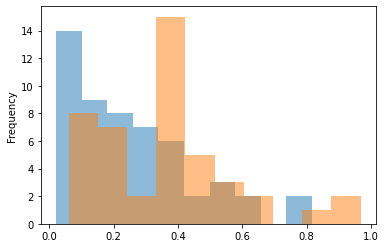

In [101]:
file_tabulado[(file_tabulado['tratamiento']=='c') & (file_tabulado['frecuencia']==5)]['AR'].plot.hist(bins=10, alpha=0.5)
file_tabulado[(file_tabulado['tratamiento']=='vk') & (file_tabulado['frecuencia']==5)]['AR'].plot.hist(bins=10, alpha=0.5)

In [91]:
print(file_tabulado[(file_tabulado['tratamiento']=='c') & (file_tabulado['frecuencia']==5)]['AR'].median())
print(file_tabulado[(file_tabulado['tratamiento']=='c') & (file_tabulado['frecuencia']==5)]['AR'].std())
print(file_tabulado[(file_tabulado['tratamiento']=='vk') & (file_tabulado['frecuencia']==5)]['AR'].median())
print(file_tabulado[(file_tabulado['tratamiento']=='vk') & (file_tabulado['frecuencia']==5)]['AR'].std())

0.22547280827765143
0.19250797584931587
0.3931616062290421
0.2144851605369258


### DICRI

In [ ]:
tab = pd.read_csv('/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/seleccion/tabulado_imagenes.csv', encoding='utf-8')
del tab['Unnamed: 0']
pd.set_option('display.max_rows', None)
controles = tab[tab['tratamiento'] == 'c']
controles = controles.reset_index(drop=True)

In [ ]:
exps = os.listdir(path + 'jsons/')
experiments = []
for j in range(0,len(exps)):
    for i in range(0,len(controles)):
        if str(controles['experimento'][i]) in exps[j]:
            if str(controles['foto'][i]) in exps[j]:
                experiments.append(exps[j])

In [ ]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/'
# experiments = os.listdir(path + 'jsons/')
complete_file = pd.DataFrame()
for i in range(0,len (experiments)):
    try:
        experiment = jasonReader(path + 'jsons/' + experiments[i])
        amp_files = slicesParser_amplitudes(experiment).filter(['transient1','transient2'])
        amp_files = amp_files[:][0:33]
        transient_max = []
        for j in range(1,len(amp_files)+1):
            transient_max.append(max(amp_files['transient1'][j],amp_files['transient2'][j]))
        amp_files['transient_max'] = transient_max
        amp_files.loc[len(amp_files)+1] = (amp_files.mean())
        amp_files.loc[len(amp_files)+1] = [amp_files['transient1'][len(amp_files)]*100/amp_files['transient_max'][len(amp_files)],amp_files['transient2'][len(amp_files)]*100/amp_files['transient_max'][len(amp_files)],'']
        amp_files[str(experiments[i])] = list(range(1,len(amp_files)-1))+['promedios']+['porcentaje_max']
        complete_file = pd.concat([complete_file,amp_files], axis=1)
    except ValueError:
        print(experiments[i])

In [ ]:
complete_file.to_excel(path + 'DICRI_controles.xlsx', engine='xlsxwriter')  

### Amplitud de transitorio global vs DI

In [ ]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/json_nuevos/'
file_tabulado = pd.read_csv(path + 'tabulado_parceado.csv')
file_tabulado.head() 

In [ ]:
experiment = jasonReader(path + 'jsons/050320c8_analysis_result_8b000.json')
allSlices = experiment['slices']
for i in range(0,len(allSlices)):
    print(allSlices[i]['amplitudes'])

In [ ]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/json_nuevos/whole_cell/'
experiments = os.listdir(path)
df = pd.DataFrame()
for experiment in experiments:
    df = pd.read_csv(path + experiment, sep = '\t', index_col=0).loc['amplitudes']
    for imagen in range(0,len(file_tabulado)):
        cel = file_tabulado['célula'].loc[imagen]
        foto = file_tabulado['foto'].loc[imagen]
        if (cel in experiment) & (foto in experiment):
            print(experiment,df)

#     print (experiment, df)

### ALBUMINA

In [ ]:
# Python code demonstrate creating  
# DataFrame from dict narray / lists  
# By default addresses. 
  
import pandas as pd 
  
# intialise data of lists. 
data = {'BSA':[102, 97, 79], 
        'HSA':[65, 74, 69.5],
        'RabSA':[57, 63.3, 70],
        'RSA':[50, 51, 52],
        'PSA':[45, 48, 55]} 
  
# Create DataFrame 
df = pd.DataFrame(data)
df_mean = df.mean()
df_std = df.std()
# Print the output. 
df_std

In [ ]:
import matplotlib.pyplot as plt

plt.errorbar(df_mean.index, df_mean, yerr=df_std, xerr=None, fmt='o')
plt.ylabel('% convertion', fontdict=None, labelpad=None,loc=None)
plt.savefig('/media/leandro/Volumen1TB/Lean/Albumina/%alb_convertion.png')

In [ ]:
cambios_fq = pd.read_csv('/media/leandro/Volumen1TB/Lean/Albumina/cambios_fq_completos.csv', sep= ' ')

In [ ]:
cambios_fq.loc()